In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [406]:
class Mixture_splitter:

    max_components = 10

    @staticmethod
    def mu(xl : pd.DataFrame) -> np.ndarray:
        return np.array(xl.mean())

    @staticmethod
    def cov_matrix(xl : pd.DataFrame, mu : np.ndarray) -> np.ndarray:
        m, k = xl.shape
        cov = np.zeros((k, k))
        for i in range(m):
            current = xl.values[i]
            cov += np.array([current - mu]) * np.array([current - mu]).T

        return cov / (m - 1)

    @staticmethod
    def likehood(x : np.ndarray, mu : float, cov : np.ndarray) -> float:
        xx = np.array([x - mu])
        det = np.linalg.det(cov + 0.000001 * np.random.rand(2, 2))
        inv = np.linalg.inv(cov + 0.000001 * np.random.rand(2, 2))
        n = len(x)
        return 1 / (np.sqrt((2 * np.pi)**n) * det) * np.exp(-0.5 * np.matmul(np.matmul(xx, inv), xx.T))


    def phi(self, xl : pd.DataFrame, theta : list[dict], weights : list) -> list:
        result = []
        for i in range(len(xl)):
            current = 0
            x = xl.values[i]
            for j in range(len(theta)):
                current += weights[j] * self.likehood(x, theta[j]['mu'], theta[j]['cov'])
            result.append((i, current.flatten()[0]))

        return result

    @staticmethod
    def diff(a : np.ndarray, b : np.ndarray) -> float:
        return np.sum(abs(a - b))


    def EM_fixed(self, xl : pd.DataFrame, k : int, theta : list[dict],
            eps : float, weights : list) -> tuple[np.ndarray, list[dict]]:
        m, fc = xl.shape
        g = np.zeros((m, k))
        g_0 = np.zeros((m, k))
        MAX_ITERATIONS = 100

        for step in range(1, MAX_ITERATIONS + 1):
            for i in range(m): #E-step
                current = xl.values[i]
                for j in range(k):
                    g_0[i][j] = g[i][j]
                    num = weights[j] * self.likehood(current, theta[j]['mu'], theta[j]['cov'])
                    denom = np.sum([self.likehood(current, theta[s]['mu'], theta[s]['cov']) for s in range(k)])
                    g[i][j] = num / denom

            for j in range(k): #M-step
                weights[j] = np.sum(g[:, j]) / m
                mu = np.zeros(fc)

                for i in range(fc):
                    mu[i] = np.dot(g[:, j], xl.values[:, i]) / (m * weights[j])

                cov = np.zeros((2, 2))
                cov[0][0] = np.dot(g[:, j], (xl.values[:, 0] - mu[0])**2) / (m * weights[j])
                cov[1][1] = np.dot(g[:, j], (xl.values[:, 1] - mu[1])**2) / (m * weights[j])

                theta[j] = {'mu' : mu, 'cov' : cov}

            if self.diff(g, g_0) < eps:
                break

        return weights, theta


    def EM_additive(self, xl : pd.DataFrame, m_0 : int,
                    eps : float, R : float) -> tuple[np.ndarray, list[dict]]:
        m, fc = xl.shape
        mu = self.mu(xl)
        cov = self.cov_matrix(xl, mu)

        theta = [{"mu" : mu, "cov" : cov}]
        k = 1
        weights = [1]

        for step in range(1, self.max_components + 1):
            cur_phi = self.phi(pd.DataFrame(data=xl), theta, weights)
            p_max = max(cur_phi, key=lambda x : x[1])[1] * R
            u = list(map(lambda z: z[0], filter(lambda z: z[1] < p_max, cur_phi)))

            if len(u) < m_0 and k > 1:
                print(k, theta)
                break

            k = step
            weight_k = len(u) / m
            weights = list(map(lambda z: z * (1 - weight_k), weights))
            weights.append(weight_k)
            mu = self.mu(xl.iloc[u])
            cov = self.cov_matrix(xl.iloc[u], mu)
            theta.append({"mu" : mu, "cov" : cov})

            weights, theta = self.EM_fixed(xl, k, theta, eps, weights)

        return weights, theta

В этот раз мы тоже строим предсказания по формуле:
$$a(x) = \arg \max_{y \in Y} λ_y P_y p_y(x)$$
Нам все также надо найти оценки $\hat{P_y} \hat{p_y}(x)$. Для $\hat{P_y}$ подход оставим, а для функций правдоподобия...
Мы хотим как можно более точно описать поведение и природу объектов $x_i \in X^l$. Для этого положим, что:
$$p_y(x) = \sum_{i = 1}^{k} w_i p_x(i), \sum_{i = 1}^{k} w_i = 1$$
то есть мы раскладываем исходную выборку на **смесь некоторых компонент**. Тут $w_i$ - априорная вероятность $i$-той смеси, $p_x(i)$ - плотность распределения(все распределения должны быть одного рода). Таким образом, мы по сути можем приблизительно описать любую плотность распределия случайной величины. Но нам не известно какие надо брать $p_x(i)$, поэтому зададим их моделью вида:
$$p_x(i) = ϕ(x, \theta_i)$$
Так как мы используем принцпип максимума правдоподобия, нам требуется решить задачу вида:
$$p_y(x) = \sum_{i = 1}^{k} w_i ϕ(x, \theta_i) → \max_Θ$$
$$Θ = (w_1, ..., w_k, \theta_1, ..., \theta_k)$$
Решая напрямую, получаем сложную оптимизационную задачу. Нам такого не надо, поэтому воспользуемся **EM-алгоритмом**. \\
****
**E - шаг** \\
$p(x, θ_j) = p_y(x)P(θ_j|x) = w_jp_j(x)$ - плотность вероятности того, что объект $x$ получен из $j$-той компоненты смеси. Оценим теперь:
$$g_{ij} = P(θ_j|x) = \frac{w_jp_j(x_i)}{\sum_{s=1}^{k} w_sp_s(x_i)}$$
Очевидно, что знаменатель это просто формула смеси. \\
**М - шаг**
\begin{equation*}
 \begin{cases}
   Q(Θ)=\ln ∏_{i=1}^{m}p(x_i) = \sum_{i = 1}^{m} ln \sum_{j=1}^{k}w_jp_j(x_i) → \max_Θ
   \\
   \sum_{i = 1}^{k} w_i = 1
 \end{cases}
\end{equation*}
Тут надо взять Лагранжиан(мне страшно представить лицо человека, который реально распишет этот шаг в отчете), приравнять сначала частные производные по $w_j$ к нулю, потом по $θ_j$(понятно, что наши плотности это $\phi(x_i, θ_j))$. И тогда мы получим задачу вида:
$$θ_j = \arg \max_{θ} \sum_{i = 1}^{m} g_{ij} \ln \phi(x_i, θ)$$
$$w_j = \frac{1}{m}\sum_{i = 1}^{m} g_{ij}$$
Будем повторять наши шаги пока наши параметры не стабилизируются, то есть
$$|g_{ij}^0 - g_{ij}| > ϵ$$
$g_{ij}^0$ - значения полученные на предыдущем шаге алгоритма(обозначение сомнительное).
****
**EM-алгоритм** с последовательным добавлением компонент. \\
В обычном алгоритме мы задаем параметр $k$ - количество компонент(он фигурирует там в сумме) вручную, но нам может не хватить компонент или мы можем с ними переборщить, тогда мы или получим качество хуже, или, вообще говоря, переобучимся, ведь мы будет точно описывать только наше облако точек, по сути просто научимся описывать не смесь распрделений, а само распределение точек(даже если на первый взляд кажется, что закона нет). Мы будем делать следующее: \\
Параметры: $R$ - маскимальный разброс правдоподобия объектов, $m_0$ - минимальная длина выборки. Далее:


1.   $θ_1 = \arg \max_{θ} \sum_{i = 1}^{m} \ln \phi(x_i, θ)$
2.   Будем постепенно добавлять компоненты: for $k ∈ 2..m$
3.   $U = \{x_i ∈ X^l | p_y(x_i) < \max_{s} p_y(x_s) / R\} $
4.   Если $|U| < m_0$ - возвращаем $Θ$
5.   $θ_k = \arg \max_{θ} \sum_{i \in U} \ln \phi(x_i, θ), w_k = \frac{1}{m} |U|$
6.   $EM(k, Θ, ϵ)$ \\




По сути, мы выбираем объекты, которые нихудшим образом описываются текущей смесью, а затем пытаемся описать их новой компонентой смеси, которой мы сначала задаем начальное приближение $θ_k$, а потом уточняем его просто EM-алгоритмом.

In [407]:
class Radial_basis_function(Mixture_splitter):

    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None
        self.weights = {}
        self.theta = {}
        self.probas = {}


    def fit(self, X : pd.DataFrame, y : pd.DataFrame, eps : float, R : float) -> None:
        self.X = X
        self.y = y
        self.classes = np.unique(self.y)

        self.weights[0], self.theta[0] = self.EM_additive(X.iloc[y[y == 0].index], np.floor(len(y[y == 0]) / 5), eps, R)
        self.weights[1], self.theta[1] = self.EM_additive(X.iloc[y[y == 1].index], np.floor(len(y[y == 1]) / 5), eps, R)

        self.probas[0] = len(y[y == 0]) / len(y)
        self.probas[1] = len(y[y == 1]) / len(y)


    def predict(self, point : list | np.ndarray) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = self.probas[c]
            theta = np.nan_to_num(self.theta[c])
            weights = self.weights[c]
            proba = 0

            for j in range(len(theta)):
                proba += weights[j] * self.likehood(point, theta[j]["mu"], theta[j]["cov"])
            posterior_probas.append(prior_proba * proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

    def get_distribution_params(self) -> dict:
        return self.theta

На самом деле мы полагаем $ϕ(x, θ) = N(x, \mu, Σ)$. Да, все то же многомерное нормальное распредение:
$$ N(x, μ, Σ) = \frac{1}{\sqrt{(2 π)^n |Σ|}} e^{-\frac{1}{2} (x-μ)^T Σ^{-1} (x-\mu)} $$
Выясняется, что мы можем описать любую плотсность распределения с помощью линейной комбинации таких плотностей. 🎆🎆🎆 \\
Теперь, когда мы подставим это в формулу смеси, мы получим сеть радикальных функций. К тому же мы теперь можем просто аналитиечски посчитать значения параметров распредления $θ_k = (\mu_k, Σ_k)$:
$$\mu = \frac{1}{mw_j}\sum_{i = 1}^{m} g_{ij}x_i$$
$$Σ = \frac{1}{mw_j}\sum_{i = 1}^{m} g_{ij}(x_i - \mu)(x_i - \mu)^T$$
Тогда классификатор будет иметь вид:
$$a(x) = \arg \max_{y \in Y} λ_y \hat{P_y} ∑_{j = 1}^{k_y}w_{yi} N(x, μ_{yi}, Σ_{yi})$$

In [ ]:
def generate(mu : float, sigma : float, size=100) -> np.ndarray:
    return np.array(np.random.normal(mu, sigma, size))


def generate_feature(x : np.ndarray, y : np.ndarray):
    return np.concatenate((x, y))


def generate_sample_data(size = 100, option : bool = False) -> pd.DataFrame:
    x = generate_feature(generate(0.2, 0.05, size=size // 2), generate(0.4, 0.05, size=size // 2))
    y = generate_feature(generate(0.4, 0.05, size=size // 2), generate(0.6, 0.05, size=size // 2))
    labels = np.array([0] * (size // 2) + [1] * (size // 2))
    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [386]:
x, y, labels, data = generate_sample_data(100, option=True)

In [387]:
model = Radial_basis_function()
model.fit(data[['x', 'y']], data.label, eps=1e-5, R=0.1)

<ipython-input-384-cb1494dfba2d>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g[i][j] = num / denom


2 [{'mu': array([0.16869015, 0.42070659]), 'cov': array([[0.00227389, 0.        ],
       [0.        , 0.00148707]])}, {'mu': array([0.22456631, 0.39863621]), 'cov': array([[0.00129809, 0.        ],
       [0.        , 0.00273159]])}, {'mu': array([0.2094668 , 0.40257236]), 'cov': array([[ 0.00637187, -0.00528133],
       [-0.00528133,  0.01114575]])}]
2 [{'mu': array([0.36795661, 0.59861666]), 'cov': array([[0.00084967, 0.        ],
       [0.        , 0.00266088]])}, {'mu': array([0.43873243, 0.60399134]), 'cov': array([[0.00190332, 0.        ],
       [0.        , 0.00273953]])}, {'mu': array([0.40508928, 0.63193101]), 'cov': array([[0.01033288, 0.00196087],
       [0.00196087, 0.00875799]])}]


In [ ]:
def make_classification_map(best_model : object, x : np.ndarray, y : np.ndarray, data : pd.DataFrame) -> None:
    all_points = []
    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1, 0.01):
          all_points.append([i, j])

    predictions = []
    for i in all_points:
        predictions.append(model.predict(i))


    df = pd.DataFrame(data={'x' : [point[0] for point in all_points], 'y' : [point[1] for point in all_points], 'Label' : predictions})
    sns.scatterplot(data=df, x='x', y='y', hue='Label', palette="magma")
    sns.scatterplot(data=data, x='x', y='y', hue='label')

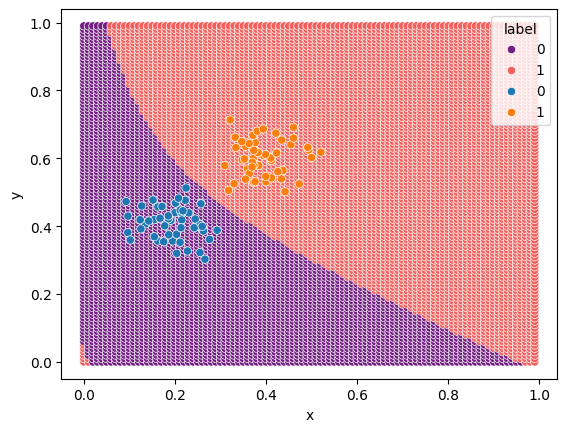

In [388]:
make_classification_map(model, x, y, data)

Как видно, алгоритм работает для одного распределения. Скорее всего нам просто хватило одной компоненты, чтобы описать плотность распрделения двух этих "облак" точек

<Axes: xlabel='x', ylabel='y'>

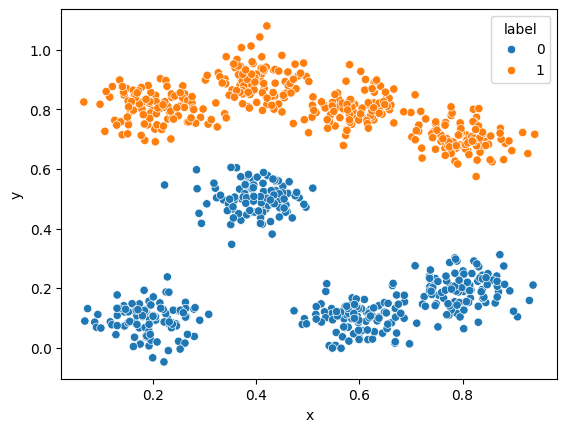

In [408]:
def generate_array(m1, d1, m2, d2,  size=100):
    return np.concatenate(
        (
            np.random.normal(m1, d1, size=size),
            np.random.normal(m2, d2, size=size)
        )
    )


df = pd.DataFrame(
    {
        'x': np.concatenate((
            generate_array(0.2, 0.05, 0.4, 0.05),
            generate_array(0.4, 0.05, 0.6, 0.05),
            generate_array(0.6, 0.05, 0.8, 0.05),
            generate_array(0.8, 0.05, 0.2, 0.05),
        )),
        'y': np.concatenate((
            generate_array(0.1, 0.05, 0.9, 0.05),
            generate_array(0.5, 0.05, 0.8, 0.05),
            generate_array(0.1, 0.05, 0.7, 0.05),
            generate_array(0.2, 0.05, 0.8, 0.05),
        )),
        'label': np.array(([0] * 100 + [1] * 100) * 4)
    }
)

X = df[['x', 'y']]
y = df.label

sns.scatterplot(data=df, x='x', y='y', hue='label')

In [ ]:
model = Radial_basis_function()
model.fit(df[['x', 'y']], df.label, eps=1e-2, R=0.1)

In [412]:
print(model.get_distribution_params())

{0: [{'mu': array([0.53094203, 0.1298094 ]), 'cov': array([[0.06605789, 0.        ],
       [0.        , 0.00459586]])}, {'mu': array([0.39877707, 0.50164246]), 'cov': array([[0.00272312, 0.        ],
       [0.        , 0.00252761]])}, {'mu': array([0.4998519, 0.219057 ]), 'cov': array([[ 0.05376764, -0.00163546],
       [-0.00163546,  0.02900541]])}], 1: [{'mu': array([0.80883657, 0.68875122]), 'cov': array([[0.00196522, 0.        ],
       [0.        , 0.00115108]])}, {'mu': array([0.39193935, 0.91016411]), 'cov': array([[0.00123639, 0.        ],
       [0.        , 0.00292881]])}, {'mu': array([0.60470274, 0.81008307]), 'cov': array([[0.00178032, 0.        ],
       [0.        , 0.00161408]])}, {'mu': array([0.17657723, 0.80361235]), 'cov': array([[0.00169317, 0.        ],
       [0.        , 0.00287597]])}, {'mu': array([0.48036469, 0.87270262]), 'cov': array([[0.00669228, 0.        ],
       [0.        , 0.00279141]])}, {'mu': array([0.23014714, 0.80104412]), 'cov': array([[0.003

In [413]:
def plot_contours(mu, sigma):
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            diff = pos[i, j] - mu
            exponent = -0.5 * np.dot(np.dot(diff, np.linalg.inv(sigma)), diff.T)
            Z[i, j] = np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))

    return X, Y, Z

In [414]:
first = model.get_distribution_params()[0]
second = model.get_distribution_params()[1]
print(first)

[{'mu': array([0.53094203, 0.1298094 ]), 'cov': array([[0.06605789, 0.        ],
       [0.        , 0.00459586]])}, {'mu': array([0.39877707, 0.50164246]), 'cov': array([[0.00272312, 0.        ],
       [0.        , 0.00252761]])}, {'mu': array([0.4998519, 0.219057 ]), 'cov': array([[ 0.05376764, -0.00163546],
       [-0.00163546,  0.02900541]])}]


<Axes: xlabel='x', ylabel='y'>

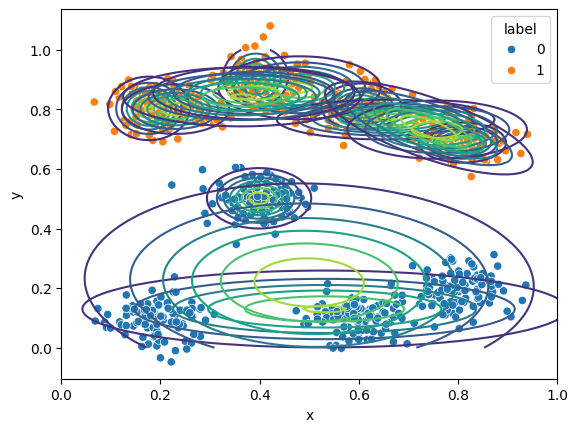

In [420]:
for i in range(len(first)):
    mu = first[i]["mu"]
    cov = first[i]["cov"]
    X, Y, Z = plot_contours(mu, cov)
    plt.contour(X, Y, Z)

for i in range(len(second)):
    mu = second[i]["mu"]
    cov = second[i]["cov"]
    X, Y, Z = plot_contours(mu, cov)
    plt.contour(X, Y, Z)

sns.scatterplot(data=df, x='x', y='y', hue='label')

In [ ]:
class Plug_in:


    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None


    @staticmethod
    def gaussian(x : np.ndarray | list, mu : np.ndarray | list, cov : np.ndarray) -> float:
        diff = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        return 1 / (np.sqrt((2 * np.pi)**len(x)) * det) * np.exp(-0.5 * np.transpose(diff) * inv * diff)


    def fit(self, X : pd.DataFrame, y : np.ndarray | pd.DataFrame) -> None:
        self.X = X
        self.y = y
        m, n = X.shape

        self.classes = np.unique(self.y)
        self.mu = {}
        self.cov = {c: np.zeros((n, n)) for c in self.classes}
        self.prior_probas = {}

        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()

            for cur in self.X.iloc[self.y[self.y == c].index].values:
                self.cov[c] += np.array([(cur - self.mu[c])]) * np.transpose(np.array([cur - self.mu[c]]))

            self.cov[c] /= m - 1

            self.prior_probas[c] = len(self.X.iloc[self.y[self.y == c].index]) / m


    def predict(self, point : np.ndarray | list) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = np.log(self.prior_probas[c])
            mu = self.mu[c]
            cov = self.cov[c]
            posterior_proba = prior_proba + np.sum(np.log(self.gaussian(point, mu, cov)))
            posterior_probas.append(posterior_proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

In [ ]:
model = Plug_in()
model.fit(data[['x', 'y']], data.label)

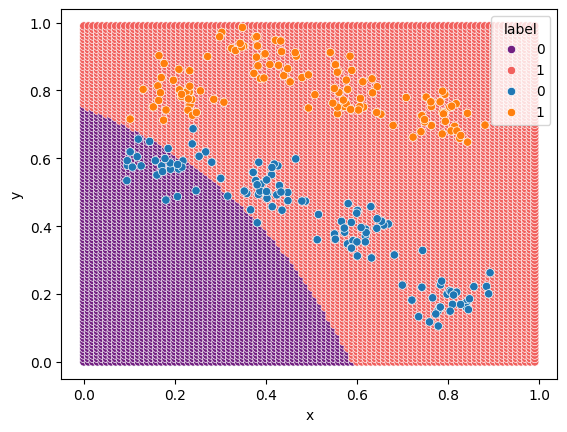

In [ ]:
make_classification_map(model, X, y, df)

А подстановочный алгоритм умер...

Естественно, алгоритм восстановления смеси плотностей будет работать наилучшим образом среди всех алгоритмов, ведь вместо того, чтобы просто полагать распределение нормальным, мы восстанавливаем распределение объекта через линейную комбинацию других. Однако, есть несколько проблем:


1.   Алгоритм вновь чувствителен к выбросам, хотя уже не так сильно как прошлые.
2.   Мы обращаем ковариационную матрицу, она может быть вырожденной или плохо обусловленной. Хотя это все не большая проблема, ведь у нас есть сразу два нормлаьных пути решения: применить регуляризацию, выбрать другой вид базисного распределения. В обоих случаяхмы пожертвуем точностью, но получим нормальный результат.
3.   Начальное приближение может оказаться сомнительным, алгоритм долго будет сходится.



Но в целом, этот алгоритм:


1.   Очень быстро сходится
2.   Алгоритм легко сделать устойчивым к шуму
3.   Гиперплоскости получаются близкими к прямым, что дает хорошую обощающую способность
4.   Мы можем легко выделить центры классов, иногда нам это надо, иногда нет, но это делается автоматически - $\mu $
5.   Даже когда распределение не является нормальным, алгоритм работает верно.



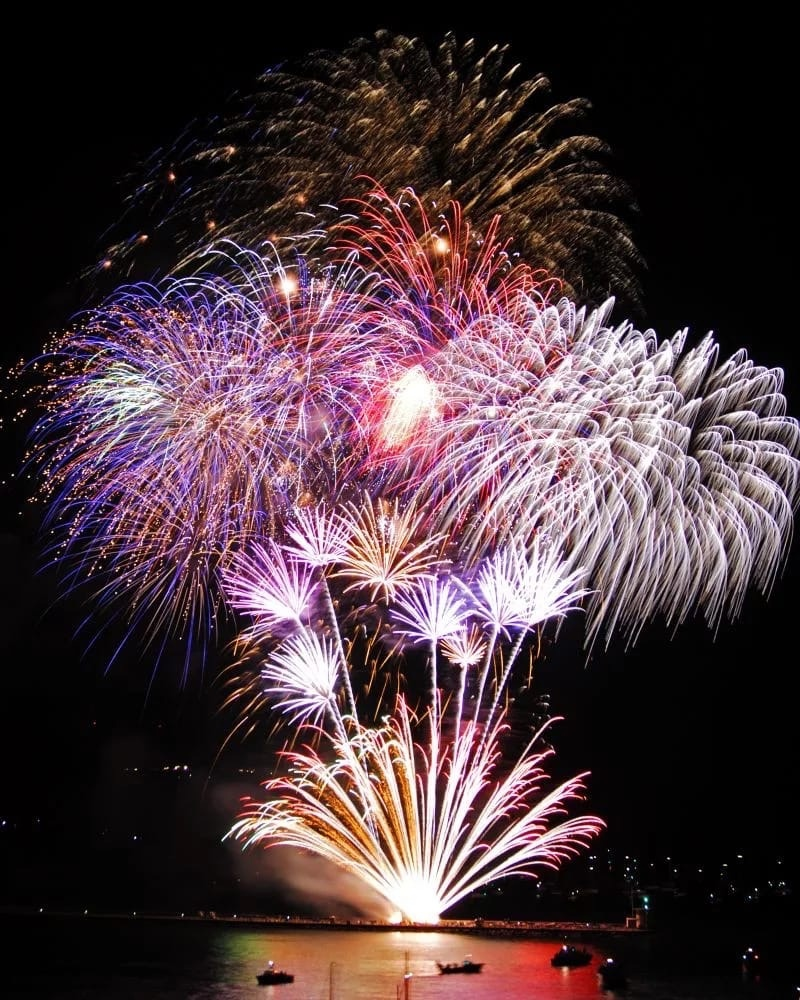